In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [46]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torchvision
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("/gdrive/MyDrive/work_space/GAN_stuff")

from utils.mnist_dataset import MNISTDataset

Constants

In [39]:
DATA_DIR = "/gdrive/MyDrive/work_space/GAN_stuff/MNIST"

IMAGE_SIZE = 32
N_CHANNELS = 1
N_LABEL_CLASSES = 10

BATCHES_DIM = 0
CHANNELS_DIM = 1

NN classes

In [18]:
# NN classes

class Generator(nn.Module):
    def __init__(self, n_latent_dims):
        super(Generator, self).__init__()
        self.init_size = IMAGE_SIZE // 4
        self.linear_1 = nn.Linear(n_latent_dims + N_LABEL_CLASSES, 128 * self.init_size ** 2)


        self.gen = nn.Sequential(
          nn.BatchNorm2d(128),
          nn.Upsample(scale_factor=2), nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
          nn.Upsample(scale_factor=2), nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
          nn.Conv2d(64, N_CHANNELS, kernel_size=3, stride=1, padding=1),
          nn.Tanh()
        )

    def forward(self, z):
        z = self.linear_1(z)
        z = z.view(z.shape[0], 128, self.init_size, self.init_size)
        img = self.gen(z)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.feature_size = IMAGE_SIZE // 2**4

        self.conv_layers = nn.Sequential(
            nn.Conv2d(N_CHANNELS + N_LABEL_CLASSES, 16, kernel_size=3, stride=2, padding=1), nn.LeakyReLU(0.2), 
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2)
        )
        
        self.classifier = nn.Sequential(
                                        nn.Linear(128 * self.feature_size**2, 1),
                                        nn.Sigmoid()
                                       )

    def forward(self, img):
        features = self.conv_layers(img)
        decision = self.classifier(features.view(features.shape[0], -1))
        return decision


Utility functions

In [31]:
def get_noise_vector(z_size):
	return torch.rand(z_size)
 
def get_one_hot_vectors(label_batch):
  one_hot_vectors = torch.zeros(label_batch.shape[0], N_LABEL_CLASSES)
  one_hot_vectors[np.arange(label_batch.shape[0]), label_batch[:,0]] = 1
  return one_hot_vectors

def get_one_hot_mask(label_batch):
  one_hot_vectors = get_one_hot_vectors(label_batch).unsqueeze(-1).unsqueeze(-1)
  one_hot_mask = one_hot_vectors.repeat(1, 1, IMAGE_SIZE, IMAGE_SIZE)
  return one_hot_mask


Training config

In [44]:
device = 'cuda'

n_latent_dims = 100

n_epochs = 100
batch_size = 16

Initialization

In [32]:
train_dataset = MNISTDataset(DATA_DIR, subset_name='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

generator = Generator(n_latent_dims).to(device)
discriminator = Discriminator().to(device)

gen_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discrim_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss(reduction='mean')

Training loop

Epoch: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



D loss: 0.1078174627757247 | G loss: 6.2938769500710565


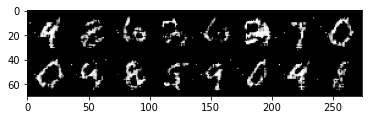

tensor([4, 8, 6, 2, 6, 2, 7, 0, 0, 4, 8, 5, 9, 0, 4, 8])
Epoch: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



D loss: 0.08368893517924697 | G loss: 7.244432612260712


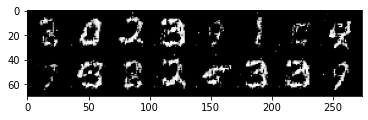

tensor([8, 0, 2, 3, 9, 1, 5, 4, 7, 5, 8, 2, 5, 3, 3, 9])
Epoch: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



D loss: 0.10782800700240232 | G loss: 6.554412984787655


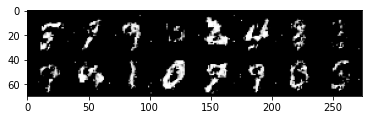

tensor([5, 9, 9, 6, 2, 4, 8, 3, 9, 4, 1, 0, 7, 9, 0, 5])
Epoch: 4


KeyboardInterrupt: ignored

In [47]:
for epoch in range(1, n_epochs):

  print("\nEpoch:", epoch)
  epoch_discrim_loss = 0
  epoch_gen_loss = 0

  for batch in tqdm(train_loader):

    # Discriminator phase --
    real_images = batch['image'].to(device).float()
    class_labels_real = batch['class-label'].to(device).long()
    one_hot_mask_real = get_one_hot_mask(class_labels_real).to(device).long()
    ones = torch.ones(real_images.shape[0], 1, device=device)

    noise_batch = get_noise_vector(z_size=(batch_size, n_latent_dims)).to(device)
    class_labels_fake = torch.randint(0, N_LABEL_CLASSES, size=(batch_size, 1))
    one_hot_vectors_fake = get_one_hot_vectors(class_labels_fake).to(device).long()
    one_hot_mask_fake = get_one_hot_mask(class_labels_fake).to(device).long()

    with torch.no_grad():
      fake_images = generator(torch.cat([noise_batch, one_hot_vectors_fake], dim=1))
    zeros = torch.zeros(fake_images.shape[0], 1, device=device)

    discrim_optimizer.zero_grad()
    reals_loss = criterion(discriminator(torch.cat([real_images, one_hot_mask_real], dim=CHANNELS_DIM)), ones)
    fakes_loss = criterion(discriminator(torch.cat([fake_images, one_hot_mask_fake], dim=CHANNELS_DIM)), zeros)
    discrim_loss = (reals_loss + fakes_loss) / 2
    discrim_loss.backward(retain_graph=True)
    discrim_optimizer.step()


    # Generator phase --
    gen_optimizer.zero_grad()
    noise_batch = get_noise_vector(z_size=(batch_size, n_latent_dims)).to(device)
    class_labels_fake = torch.randint(0, N_LABEL_CLASSES, size=(batch_size, 1))
    one_hot_vectors_fake = get_one_hot_vectors(class_labels_fake).to(device).long()
    one_hot_mask_fake = get_one_hot_mask(class_labels_fake).to(device).long()
    fake_images = generator(torch.cat([noise_batch, one_hot_vectors_fake], dim=1))
    discrim_pred = discriminator(torch.cat([fake_images, one_hot_mask_fake], dim=CHANNELS_DIM))
    ones = torch.ones(batch_size, 1, device=device)

    gen_loss = criterion(discrim_pred, ones)
    gen_loss.backward()
    gen_optimizer.step()

    # Accumulate losses
    epoch_discrim_loss += discrim_loss.item()
    epoch_gen_loss += gen_loss.item()


  epoch_discrim_loss /= len(train_loader)
  epoch_gen_loss /= len(train_loader)
  print("D loss:", epoch_discrim_loss, "| G loss:", epoch_gen_loss)

  if epoch % 1 == 0:
    grid = torchvision.utils.make_grid(fake_images.cpu().detach())
    plt.imshow(grid.permute(1,2,0))
    plt.show()
    print("Labels:", class_labels_fake.squeeze())



tensor([[0.4217, 0.3376, 0.6501],
        [0.0981, 0.6784, 0.5426],
        [0.7805, 0.9909, 0.1721]])